In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import yfinance as yf
from scipy.optimize import minimize

In [3]:
today = datetime.date.today()
week_ago = today - datetime.timedelta(days=7)

In [4]:
assets_dict = {
    'Bitcoin': {
        'color': '#F7931A',
        'symbol': 'BTC',
        'current_price': yf.Ticker('BTC-USD').history(period='1d')['Open'][0],
        'portfolio_amount': 0.0268, 
        'kind': 'crypto'
    },
    'Ethereum': {
        'color': '#627EEA',
        'symbol': 'ETH',
        'current_price': yf.Ticker('ETH-USD').history(period='1d')['Open'][0],
        'portfolio_amount': 0, 
        'kind': 'crypto'
    },
    'Lido Staked Ether': {
        'color': '#AEAEAE',
        'symbol': 'STETH',
        'current_price': yf.Ticker('STETH-USD').history(period='1d')['Open'][0],
        'portfolio_amount': 0.56604, 
        'kind': 'crypto'
    },
    'Tether': {
        'color': '#26A17B',
        'symbol': 'USDT',
        'current_price': yf.Ticker('USDT-USD').history(period='1d')['Open'][0],
        'portfolio_amount': 206,
        'kind': 'crypto'
    },
    'Chainlink': {
        'color': '#2A5ADA',
        'symbol': 'LINK',
        'current_price': yf.Ticker('LINK-USD').history(period='1d')['Open'][0],
        'portfolio_amount': 31.29212,
        'kind': 'crypto'
    },
    'S&P 500': {
        'color': '#000000',
        'symbol': 'VOO',
        'current_price': yf.Ticker('VOO').history(period='1d')['Open'][0],
        'portfolio_amount': 1,
        'kind': 'stock'
    }
}

In [5]:
invesments = pd.DataFrame(assets_dict).transpose()
for index in invesments.index:
    if invesments.loc[index, 'portfolio_amount'] <= 0:
        invesments.drop(index, axis=0, inplace=True)

In [6]:
invested = invesments['current_price'] * invesments['portfolio_amount']

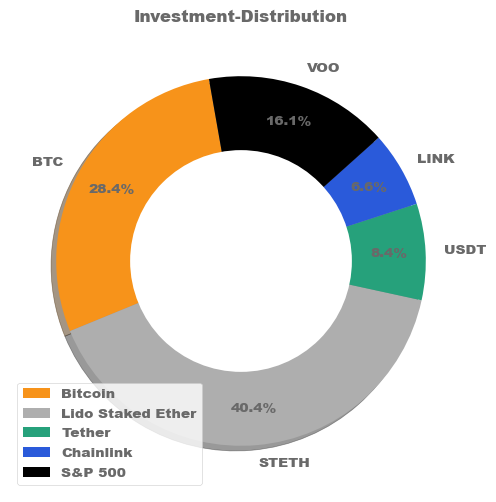

In [28]:
color_codes = invesments['color'].to_list()
names = invesments.index
labels = invesments['symbol'].to_list()
slices = invested.to_list()

fig = plt.figure(figsize=(6, 6))
ted_ed_pie_style = {
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'patch.edgecolor': 'w',
    'patch.linewidth': 0.5,
    'text.color': 'dimgray',
    'font.family': 'Arial Black',
    'font.weight': 'bold',
    'axes.prop_cycle': plt.cycler(color=color_codes)
    
}


plt.style.use(ted_ed_pie_style)

# Create a pie chart
plt.pie(x=slices, labels=labels, shadow=True, autopct='%1.1f%%', startangle=100, pctdistance=0.8)

# Draw a circle at the center (for "donut" style)
centre_circle = plt.Circle((0, 0), 0.6, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


plt.title('Investment-Distribution')
plt.legend(names)
plt.show()

In [7]:
# making the price history DataFrame
my_assets = [asset for asset in assets_dict if assets_dict[asset]['portfolio_amount'] > 0]

for asset in assets_dict.keys():
    if assets_dict[asset]['kind'] == 'crypto':
        assets_dict[asset]['symbol'] = assets_dict[asset]['symbol']+'-USD'

prices_list = []
for asset in my_assets:
    Open = yf.Ticker(assets_dict[asset]['symbol']).history(period='5y')['Open']
    Open.index = pd.DatetimeIndex(Open.index.date)
    prices_list.append(Open)

price_history = pd.concat(prices_list, axis=1)
price_history.columns = my_assets
price_history.fillna(method='ffill', inplace=True)
price_history.fillna(method='backfill', inplace=True, limit=1)

In [8]:
price_history.tail()

,Bitcoin,Lido Staked Ether,Tether,Chainlink,S&P 500
2023-06-08,26347.654297,1824.856201,1.000157,5.913884,391.959991
2023-06-09,26505.923828,1831.873901,1.000203,5.995561,395.049988
2023-06-10,26481.761719,1830.366821,1.000012,5.986423,395.049988
2023-06-11,25854.031250,1741.893555,1.000481,5.240856,395.049988
2023-06-12,25938.015625,1745.888916,1.000360,5.173856,395.049988


In [9]:
# making a DataFrame for my portfolio
portfolio_movment = pd.DataFrame(columns=price_history.columns)

for asset in price_history.columns:
    portfolio_movment[asset] = price_history[asset] * assets_dict[asset]['portfolio_amount']
    
portfolio_movment.columns = [f'{column} Holdings'for column in portfolio_movment.columns]
portfolio_movment['Total Holdings'] = portfolio_movment[[column for column in portfolio_movment.columns]].sum(axis=1)
portfolio_movment.index = pd.DatetimeIndex(portfolio_movment.index.date)

In [10]:
portfolio_movment.tail()

,Bitcoin Holdings,Lido Staked Ether Holdings,Tether Holdings,Chainlink Holdings,S&P 500 Holdings,Total Holdings
2023-06-08,706.117135,1032.941604,206.032342,185.057973,391.959991,2522.109045
2023-06-09,710.358759,1036.913903,206.041821,187.613818,395.049988,2535.978288
2023-06-10,709.711214,1036.060836,206.002480,187.327867,395.049988,2534.152385
2023-06-11,692.888037,985.981428,206.099088,163.997500,395.049988,2444.016041
2023-06-12,695.138819,988.242962,206.074089,161.900931,395.049988,2446.406788


In [11]:
# Different types of returns
def arithmetic_returns(price):
    return (price/price.shift(1)) - 1

def logarithmic_returns(price):
    return np.log(price/price.shift(1))

# making the return history DataFrame
return_history = pd.DataFrame(columns=[f'{asset} return' for asset in price_history.columns])

for asset in price_history.columns:
    return_history[f'{asset} return'] = logarithmic_returns(price_history[asset])
return_history.index = pd.DatetimeIndex(return_history.index.date)

In [12]:
return_history.tail()

,Bitcoin return,Lido Staked Ether return,Tether return,Chainlink return,S&P 500 return
2023-06-08,-0.033148,-0.025442,-0.000013,-0.056924,-0.004353
2023-06-09,0.005989,0.003838,0.000046,0.013717,0.007853
2023-06-10,-0.000912,-0.000823,-0.000191,-0.001525,0.000000
2023-06-11,-0.023990,-0.049544,0.000469,-0.133009,0.000000
2023-06-12,0.003243,0.002291,-0.000121,-0.012867,0.000000


In [13]:
low = pd.DataFrame(portfolio_movment.iloc[portfolio_movment['Total Holdings'].argmin()]).transpose()
peek = pd.DataFrame(portfolio_movment.iloc[portfolio_movment['Total Holdings'].argmax()]).transpose()

In [29]:
from forex_python.converter import CurrencyRates

def get_dollar_to_shekel_rates(date):
    try:
        c = CurrencyRates()
        shekel_rates = c.get_rate(base_cur='USD', dest_cur='ILS', date_obj=date)
        return shekel_rates
    except Exception:
        fallback_date = date - datetime.timedelta(days=1)
        return get_dollar_to_shekel_rates(fallback_date)  # Recursive call with the updated fallback date


today = datetime.date.today()
week_ago = today - datetime.timedelta(days=7)

In [ ]:
total_in_ILS = pd.DataFrame(portfolio_movment['Total Holdings'] * get_dollar_to_shekel_rates(today))

In [ ]:
from IPython.display import Markdown
font = 'monospace'
shekel_balance = total_in_ILS.iloc[-1].values[0]
dollar_balance = portfolio_movment['Total Holdings'].iloc[-1]

dollar_format = "{:,.0f}".format(dollar_balance)
shekel_format = "{:,.0f}".format(shekel_balance)

formatted_balance = f"<span style='font-weight: bold; font-size: 24px; font-family: {font};'>ILS: {shekel_format} USD: {dollar_format}</span>"
Markdown(formatted_balance)

In [ ]:
log_ret = np.log(price_history/price_history.shift(1))

In [ ]:
num_ports = 50000
all_weights = np.zeros((num_ports, len(my_assets)))

ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_ratios = np.zeros(num_ports)

for ind in range(num_ports):
    # Assign random weights to my current portfolio
    weights = np.random.random(len(my_assets))
    weights = weights/np.sum(weights)
    all_weights[ind, :] = weights
    
    # Calculate and save the data about the new portfolio
    ret_arr[ind] = np.sum((return_history.mean() * weights) * 252)
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252,weights)))
    sharpe_ratios[ind] = ret_arr[ind]/vol_arr[ind]

In [ ]:
maxi = sharpe_ratios.argmax()
{asset: weight for asset, weight in zip(my_assets, all_weights[maxi, :])}

In [ ]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum((return_history.mean() * weights) * 252)
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252,weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def check_sum(weights):
    return np.sum(weights) - 1

def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

cons = ({'type': 'eq', 'fun': check_sum})
bounds = [(0, 1) for i in range(len(my_assets))]
init_guess = [1/len(my_assets) for _ in range(len(my_assets))]

In [ ]:
# The best possible sharpe ratio for your portfolio
def optimal_portfolio():
    optimal_results = minimize(neg_sharpe, init_guess, method='slsqp',bounds=bounds, constraints=cons)
    return get_ret_vol_sr(optimal_results.x)

In [ ]:
def minimize_volatillity(weights):
    return get_ret_vol_sr(weights)[1]

y_frontier = np.linspace(ret_arr.min(), ret_arr.max())
frontier_volatillity = []

# Finding the lowst volatillity for highst possible return
for possible_return in y_frontier:
    cons = ({'type': 'eq', 'fun': check_sum},
            {'type': 'eq', 'fun': lambda w: get_ret_vol_sr(w)[0]-possible_return})
    result = minimize(minimize_volatillity, init_guess, method='slsqp',bounds=bounds, constraints=cons)
    frontier_volatillity.append(result['fun'])

In [ ]:
plt.figure(figsize=(8, 4))
plt.scatter(vol_arr, ret_arr, c=sharpe_ratios, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
# plt.scatter(vol_arr[maxi], ret_arr[maxi], c='red', ec='black', s=75, label='most optimal', zorder=4)
# plt.plot(frontier_volatillity, y_frontier, 'g--', lw=3, label='efficient frontier')
plt.ylabel('Return')
plt.xlabel('Volatillity')
plt.title('Portfolio Comparison with Sharpe Ratio');
# plt.legend();

In [ ]:
optimal_portfolio()